In [1]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))

In [2]:
import numpy as np 
import scipy.fft
import scipy.integrate
from operators.SW_sqrt import RHS, psi_ln_sw
from operators.SW import solve_poisson_equation, total_mass, total_momentum, total_energy_k, integral_I0

In [3]:
import matplotlib.pyplot as plt
from mycolorpy import colorlist as mcp
import matplotlib
font = {'family' : 'serif',
        'size'   : 14}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 

# Ion Acoustic Wave SW

In [50]:
# set up configuration parameters
# number of mesh points in x
Nx =  51
# number of spectral expansions
Nv_e = 15
Nv_i = 15
# epsilon displacement in initial electron distribution
epsilon = 0.01
# velocity scaling of electron and ion
alpha_e = 1
alpha_i = 1/135
# x grid is from 0 to L
L = 10*np.pi
# spacial spacing dx = x[i+1] - x[i]
dx = L / (Nx - 1)
# time stepping
dt = 1
# final time (non-dimensional)
T = 250.
t_vec = np.linspace(0, T, int(T / dt) + 1)
# velocity scaling
u_e = 0
u_i = 0
# mass normalized
m_e = 1
m_i = 1836
# charge normalized
q_e = -1
q_i = 1

In [51]:
# velocity grid for plotting purposes
v = np.linspace(-4, 4, 10000)
# spatial grid 
x = np.linspace(0, L, Nx)

In [52]:
# initial condition of the first expansion coefficient
C_0e = ((1 / (np.sqrt(2 * np.sqrt(np.pi))))  * (1 + epsilon * np.cos(2*np.pi*x/L)) / alpha_e)
C_0i = ((1 / (np.sqrt(2 * np.sqrt(np.pi)))) * (1 + epsilon * np.cos(2*np.pi*x/L)) / alpha_i)

In [53]:
# the distribution function of electrons and protons for plotting purposes
f_0e = np.outer(C_0e, psi_ln_sw(xi=(v-u_e)/alpha_e, u_s=u_e, alpha_s=alpha_e, v=v, n=0))
f_0i = np.outer(C_0i, psi_ln_sw(xi=(v-u_i)/alpha_i, u_s=u_i, alpha_s=alpha_i, v=v, n=0))

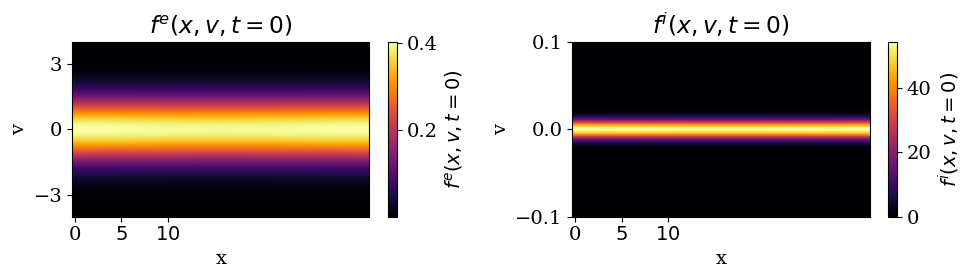

In [54]:
# plot nonlinear Landau initial condition 
fig, ax = plt.subplots(ncols=2, figsize=(10, 3))
pos = ax[0].pcolormesh(x, v, f_0e.T, cmap="inferno", vmax=np.max(f_0e))
ax[0].set_xlabel("x")
ax[0].set_xticks([0, 5, 10])
ax[0].set_xticklabels([r"0", r"$5$", r"$10$"])
ax[0].set_ylabel("v")
ax[0].set_yticks([-3, 0, 3])
cbar = fig.colorbar(pos)
cbar.ax.set_ylabel('$f^{e}(x, v, t=0)$', rotation=90)
ax[0].set_title("$f^{e}(x, v, t=0)$")

pos = ax[1].pcolormesh(x, v, f_0i.T, cmap="inferno")
ax[1].set_xticks([0, 5, 10])
ax[1].set_xticklabels([r"0", r"$5$", r"$10$"])
ax[1].set_ylim(-0.1, 0.1)
ax[1].set_yticks([-0.1, 0, 0.1])
ax[1].set_ylabel("v")
ax[1].set_xlabel("x")
cbar = fig.colorbar(pos)
cbar.ax.set_ylabel('$f^{i}(x, v, t=0)$', rotation=90)
ax[1].set_title("$f^{i}(x, v, t=0)$")
plt.tight_layout()
plt.savefig("../figs/SW/ion_acoustic/initial_condition_ion_acoustic.png", dpi=600)

In [58]:
# load simulation data
sol_midpoint_u = np.load("../data/SW/ion_acoustic/sol_midpoint_u_" + str(Nv_e) + "_dt_" + str(dt) + "_T_50.0.npy")[:, ::10]
sol_midpoint_t = np.load("../data/SW/ion_acoustic/sol_midpoint_t_" + str(Nv_e) + "_dt_" + str(dt) + "_T_50.0.npy")[::10]

# print simulation data shape
print(np.shape(sol_midpoint_u))
print(np.shape(sol_midpoint_t))

(1505, 73)
(73,)


In [59]:
# initialize the electric potential
E_midpoint = np.zeros((Nx, len(sol_midpoint_t)))

In [60]:
# initialize the states for implicit midpoint (symplectic)
state_e_midpoint = np.zeros((Nv_e, Nx-1, len(sol_midpoint_t)))
state_i_midpoint = np.zeros((Nv_i, Nx-1, len(sol_midpoint_t)))

for ii in range(len(sol_midpoint_t)):
    print("t = ", ii)
    for jj in range(Nv_e):
        # unwind the flattening in order to solve the system
        state_e_midpoint[jj, :, ii] = sol_midpoint_u[jj*(Nx-1): (jj+1)*(Nx-1), ii]
    for jj in range(Nv_i):
        state_i_midpoint[jj, :, ii] = sol_midpoint_u[Nv_e*(Nx-1) + jj*(Nx-1): Nv_e*(Nx-1) + (jj+1)*(Nx-1), ii]
    
    E_midpoint[:-1, ii] = solve_poisson_equation(state_e=state_e_midpoint[:, :, ii], 
                                               state_i=state_i_midpoint[:, :, ii], 
                                               alpha_e=alpha_e, 
                                               alpha_i=alpha_i, 
                                               dx=dx, 
                                               Nx=Nx-1, 
                                               Nv_e=Nv_e,
                                               Nv_i = Nv_i,
                                               L=L)
    E_midpoint[-1, ii] = E_midpoint[0, ii]

t =  0
t =  1
t =  2
t =  3
t =  4
t =  5
t =  6
t =  7
t =  8
t =  9
t =  10
t =  11
t =  12
t =  13
t =  14
t =  15
t =  16
t =  17
t =  18
t =  19
t =  20
t =  21
t =  22
t =  23
t =  24
t =  25
t =  26
t =  27
t =  28
t =  29
t =  30
t =  31
t =  32
t =  33
t =  34
t =  35
t =  36
t =  37
t =  38
t =  39
t =  40
t =  41
t =  42
t =  43
t =  44
t =  45
t =  46
t =  47
t =  48
t =  49
t =  50
t =  51
t =  52
t =  53
t =  54
t =  55
t =  56
t =  57
t =  58
t =  59
t =  60
t =  61
t =  62
t =  63
t =  64
t =  65
t =  66
t =  67
t =  68
t =  69
t =  70
t =  71
t =  72


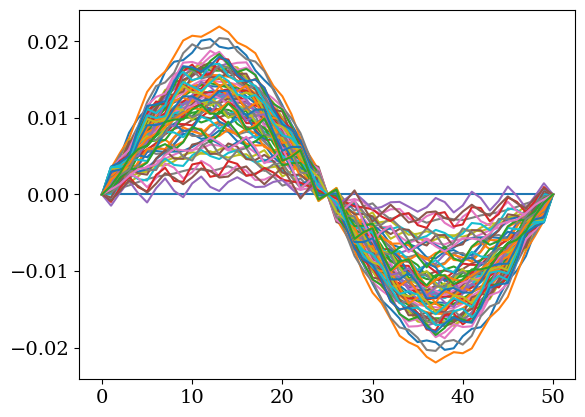

In [61]:
_  = plt.plot(E_midpoint[:, ::])

In [62]:
ion_density = np.zeros((len(x), len(sol_midpoint_t)))
for ii in range(len(sol_midpoint_t)):
    holder = 0 
    for n in range(Nv_i):
        holder += integral_I0(n=n) * state_i_midpoint[n, :, ii]
    ion_density[:-1, ii] = alpha_i * holder
    ion_density[-1, ii] = ion_density[0, ii]

In [42]:
electron_density = np.zeros((len(x), len(sol_midpoint_t)))
for ii in range(len(sol_midpoint_t)):
    holder = 0 
    for n in range(Nv_e):
        holder += integral_I0(n=n) * state_e_midpoint[n, :, ii]
    electron_density[:-1, ii] = alpha_e * holder
    electron_density[-1, ii] = electron_density[0, ii]

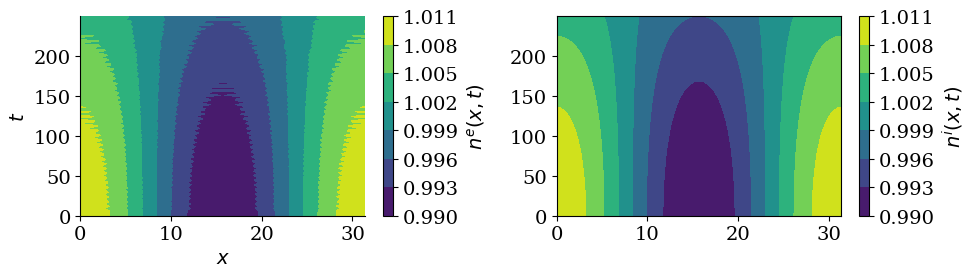

In [43]:
# plot the last spectral coefficient 
fig, ax = plt.subplots(ncols=2, figsize=(10, 3))
pos = ax[0].contourf(x, sol_midpoint_t, electron_density.T)
cbar = fig.colorbar(pos)
cbar.ax.set_ylabel(r"$n^{e}(x, t)$", rotation=90)

pos = ax[1].contourf(x, sol_midpoint_t, ion_density.T)
cbar = fig.colorbar(pos)
cbar.ax.set_ylabel(r"$n^{i}(x, t)$", rotation=90)

ax[0].set_xlabel("$x$")
ax[0].set_ylabel("$t$")
#ax.set_xticks([0, np.pi, 2*np.pi, 3*np.pi, 4*np.pi])
#ax.set_yticks([0,2, 4, 6, 8, 10])
#ax.set_xlim(0, 4*np.pi)
#ax.set_xticklabels([r"0", r"$\pi$", r"$2\pi$", r"$3\pi$", r"$4\pi$"])
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
plt.tight_layout()
plt.savefig("../figs/SW/ion_acoustic/density_electron_ion_acoustic.png")

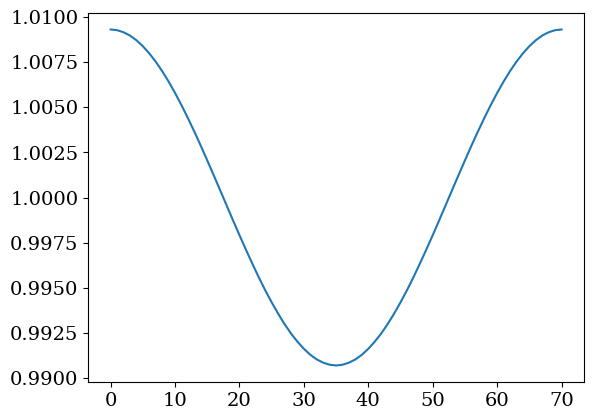

In [44]:
_ = plt.plot(electron_density[:, 2])

In [45]:
# compute electric field damping rate
E1_midpoint = np.zeros(len(sol_midpoint_t))
ion_midpoint = np.zeros(len(sol_midpoint_t))
electron_midpoint = np.zeros(len(sol_midpoint_t))

for ii in range(len(sol_midpoint_t)):
    ion_midpoint[ii] = np.abs(scipy.fft.fft(ion_density[:-1, ii])[1])
    electron_midpoint[ii] = np.abs(scipy.fft.fft(electron_density[:-1, ii])[1])
    E1_midpoint[ii] = np.abs(scipy.fft.fft(E_midpoint[:-1, ii])[1])

In [46]:
#E1_midpoint_101 = np.load("../data/SW/ion_acoustic/E1_midpoint_101_dt_1.npy")

Text(0.5, 0, '$t$')

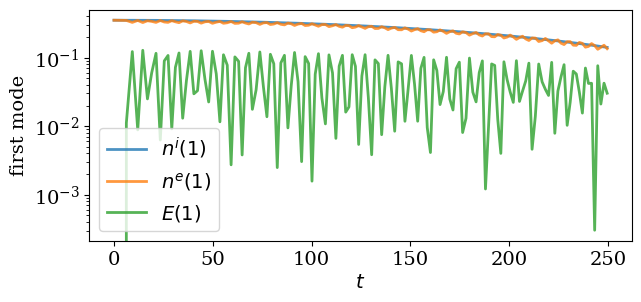

In [47]:
# plot electric field damping rate
fig, ax = plt.subplots(figsize=(7, 3))
ax.plot(sol_midpoint_t, np.abs(ion_midpoint), "-",alpha=0.8, linewidth=2, label="$n^{i}(1)$") 
ax.plot(sol_midpoint_t, np.abs(electron_midpoint), "-",alpha=0.8, linewidth=2, label="$n^{e}(1)$") 
ax.plot(sol_midpoint_t, np.abs(E1_midpoint), "-",alpha=0.8, linewidth=2, label="$E(1)$")
ax.legend()
ax.set_yscale("log")
ax.set_ylabel("first mode")
ax.set_xlabel("$t$")

ValueError: x and y must have same first dimension, but have shapes (143,) and (97,)

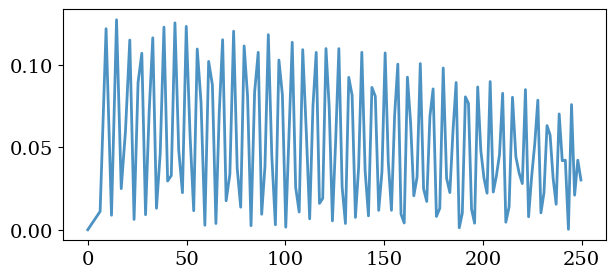

In [48]:
# plot electric field damping rate
fig, ax = plt.subplots(figsize=(7, 3))
ax.plot(sol_midpoint_t, np.abs(E1_midpoint), "-",alpha=0.8, linewidth=2, label="$E(1)$") 
ax.plot(sol_midpoint_t, np.abs(E2_midpoint), "-", alpha=0.8, linewidth=2, label="$E(2)$") 
ax.plot(sol_midpoint_t, np.abs(E3_midpoint), "-", alpha=0.8, linewidth=2, label="$E(3)$") 
ax.plot(sol_midpoint_t, np.abs(E4_midpoint), "-", alpha=0.8, linewidth=2, label="$E(4)$") 
#ax.plot(sol_midpoint_t, np.abs(E1_midpoint_101), "--", c="blue", alpha=0.8, linewidth=2, label="$N_{v}=N_{x}=51$") 
#ax.set_ylim(10**-5, 10)
#ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel("$|\hat{E}(1)|$")
ax.set_xlabel("$t$")
#ax.set_xlim(0, T)
legend = ax.legend(ncols=1, fancybox=False, shadow=False, fontsize=12, loc='lower left')
legend.get_frame().set_alpha(0)
plt.tight_layout()
plt.savefig("../figs/SW/ion_acoustic/electric_field_damping_SW.png", dpi=600)

In [30]:
np.save("../data/SW/ion_acoustic/E1_evolution_" + str(Nv_e) + ".npy", E1_midpoint)

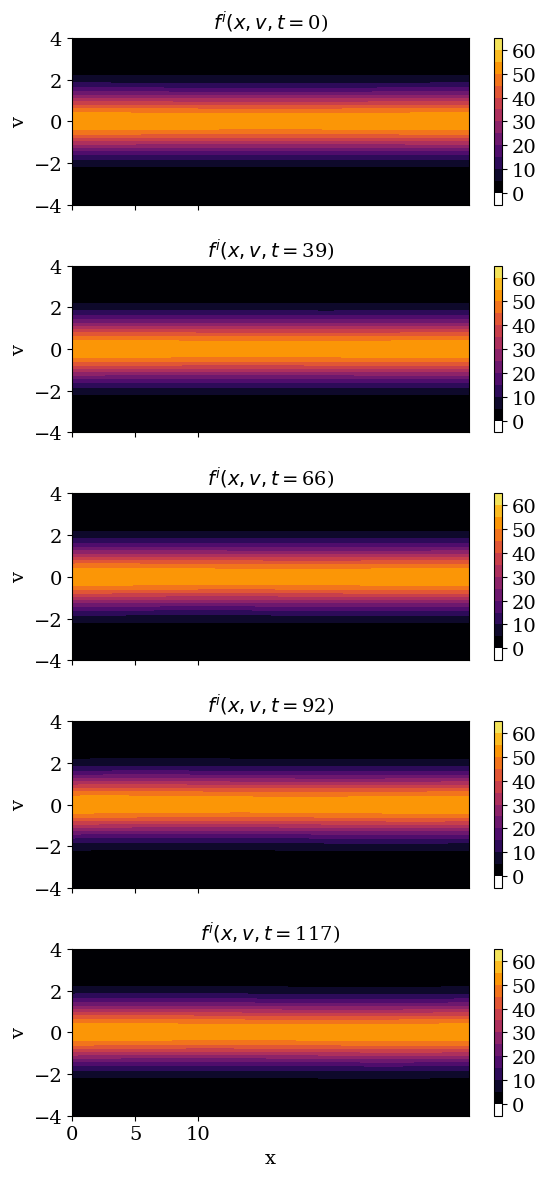

In [31]:
# plot phase space evolution 
label_list = ["0", "2.5", "5", "7.5", "10"]
fig, ax = plt.subplots(nrows=5, sharex=True, figsize=(6, 12))
for tt, ii in enumerate([0, int(10), int(20), int(30), int(40)]):
    distribution = np.zeros((Nx, len(v)))
    for jj in range(Nv_i):
        distribution += np.outer(np.append(state_i_midpoint[jj, :, ii], state_i_midpoint[jj, 0, ii]), psi_ln_sw(xi=(v)/alpha_e, u_s=u_e, alpha_s=alpha_e, v=v, n=jj))
    levels = np.append(-0.1, np.linspace(0, 70, 15))[:-1]
    colors = mcp.gen_color(cmap="inferno",n=len(levels)-1)[:-1]
    pos = ax[tt].contourf(x, v, distribution.T, levels=levels, colors=np.append(["w"], colors))
    ax[tt].set_xticks([0, 5, 10])
    ax[tt].set_xticklabels([r"0", r"5", r"10"])
    ax[tt].set_ylabel("v")
    cbar = fig.colorbar(pos)
    ax[tt].set_title("$f^{i}(x, v, t=$" + str(int(sol_midpoint_t[ii])) + ")", fontsize=14)
    #cbar.ax.set_yticks([0, 0.2, 0.4])
    #cbar.ax.set_yticklabels(["0", "0.2", "0.4"])
ax[-1].set_xlabel("x")
plt.tight_layout()
plt.savefig("../figs/SW/ion_acoustic/ion_acoustic_evolution_SW_" + str(Nv_i)+ ".png", dpi=600)

IndexError: index 100 is out of bounds for axis 2 with size 97

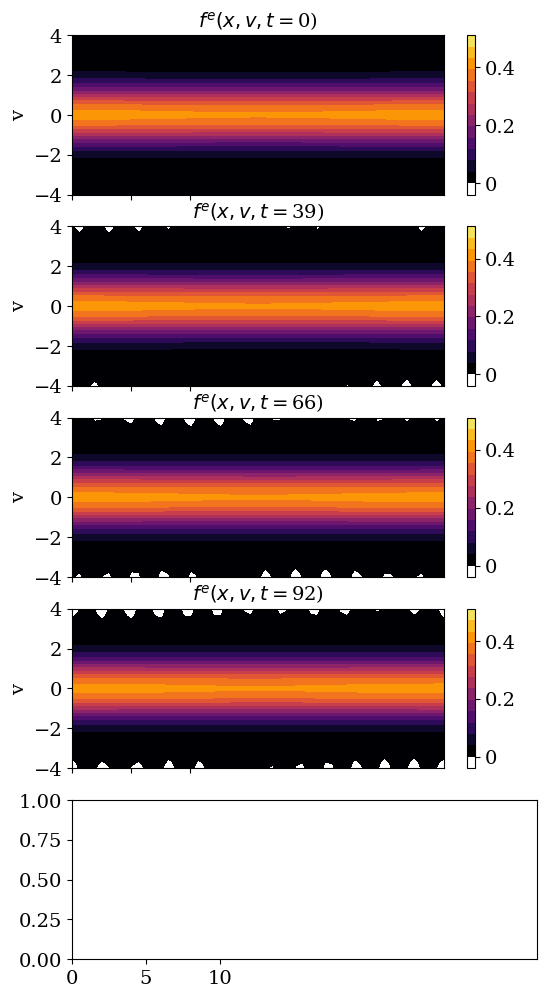

In [32]:
# plot phase space evolution 
label_list = ["0", "2.5", "5", "7.5", "10"]
fig, ax = plt.subplots(nrows=5, sharex=True, figsize=(6, 12))
for tt, ii in enumerate([0, int(10), int(20), int(30), int(100)]):
    distribution = np.zeros((Nx, len(v)))
    for jj in range(Nv_e):
        distribution += np.outer(np.append(state_e_midpoint[jj, :, ii], state_e_midpoint[jj, 0, ii]), psi_ln_sw(xi=(v)/alpha_e, u_s=u_e, alpha_s=alpha_e, v=v, n=jj))
    levels = np.append(-0.1, np.linspace(0, 0.55, 15))[:-1]
    colors = mcp.gen_color(cmap="inferno",n=len(levels)-1)[:-1]
    pos = ax[tt].contourf(x, v, distribution.T, levels=levels, colors=np.append(["w"], colors))
    ax[tt].set_xticks([0, 5, 10])
    ax[tt].set_xticklabels([r"0", r"5", r"10"])
    ax[tt].set_ylabel("v")
    cbar = fig.colorbar(pos)
    ax[tt].set_title("$f^{e}(x, v, t=$" + str(int(sol_midpoint_t[ii])) + ")", fontsize=14)
    cbar.ax.set_yticks([0, 0.2, 0.4])
    cbar.ax.set_yticklabels(["0", "0.2", "0.4"])
ax[-1].set_xlabel("x")
plt.tight_layout()
plt.savefig("../figs/SW/ion_acoustic/ion_acoustic_evolution_SW_" + str(Nv_e)+ ".png", dpi=600)

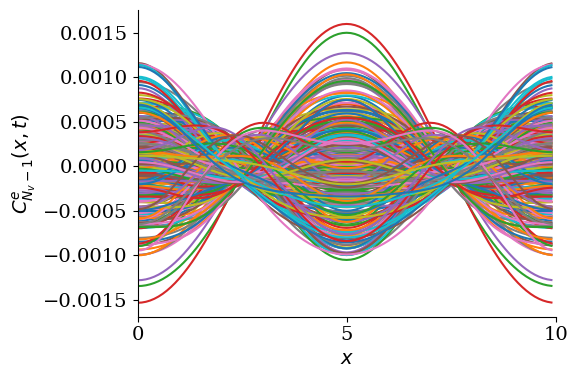

In [72]:
# plot the last spectral coefficient 
fig, ax = plt.subplots(figsize=(6, 4))
_ = plt.plot(x[:-1], state_e_midpoint[-1, :, :])
ax.set_xlabel("$x$")
ax.set_ylabel("$C_{N_{v}-1}^{e}(x, t)$")
ax.set_xticks([0, 5, 10])
#ax.set_yticks([-0.02, 0, 0.02])
ax.set_xlim(0, 10)
#ax.set_xticklabels([r"0", r"$\pi$", r"$2\pi$", r"$3\pi$", r"$4\pi$"])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tight_layout()
# plt.savefig("../figs/SW_sqrt/nonlinear_landau/poisson/last_coefficient_central.png")

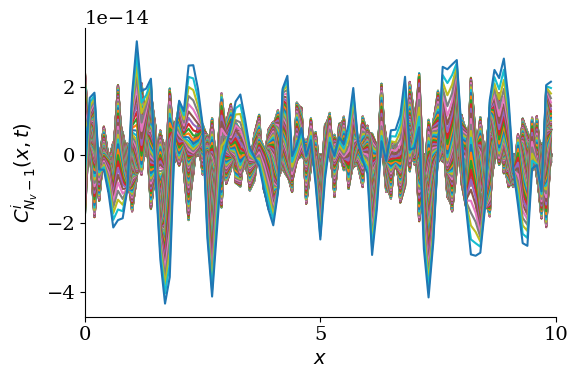

In [73]:
# plot the last spectral coefficient 
fig, ax = plt.subplots(figsize=(6, 4))
_ = plt.plot(x[:-1], state_i_midpoint[-1, :, :])
ax.set_xlabel("$x$")
ax.set_ylabel("$C_{N_{v}-1}^{i}(x, t)$")
ax.set_xticks([0, 5, 10])
#ax.set_yticks([-0.02, 0, 0.02])
ax.set_xlim(0, 10)
#ax.set_xticklabels([r"0", r"$\pi$", r"$2\pi$", r"$3\pi$", r"$4\pi$"])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tight_layout()
# plt.savefig("../figs/SW_sqrt/nonlinear_landau/poisson/last_coefficient_central.png")

# conservation laws: mass, momentum, and energy

### mass conservation

In [62]:
# compute mass conservation
mass_midpoint = np.zeros(len(sol_midpoint_t))

for ii in range(0, len(sol_midpoint_t)):
    mass_midpoint[ii] = total_mass(state=state_e_midpoint[:, :, ii], alpha_s=alpha_e, dx=dx, Nv=Nv)\
                       +total_mass(state=state_i_midpoint[:, :, ii], alpha_s=alpha_i, dx=dx, Nv=Nv)

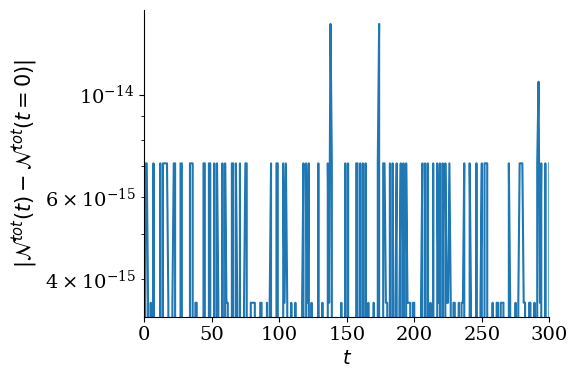

In [63]:
# plot mass conservation
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(sol_midpoint_t, np.abs(mass_midpoint - mass_midpoint[0]), "-")
ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"$|\mathcal{N}^{tot}(t) - \mathcal{N}^{tot}(t=0)|$", fontsize=15)
ax.set_xlabel("$t$")
ax.set_xlim(0, T)
plt.tight_layout()

### momentum conservation

In [64]:
# compute momentum conservation
momentum_midpoint = np.zeros(len(sol_midpoint_t))

for ii in range(0, len(sol_midpoint_t)):
    momentum_midpoint[ii] = total_momentum(state=state_e_midpoint[:, :, ii], alpha_s=alpha_e, dx=dx, Nv=Nv, m_s=m_e, u_s=u_e)\
                           +total_momentum(state=state_i_midpoint[:, :, ii], alpha_s=alpha_i, dx=dx, Nv=Nv, m_s=m_i, u_s=u_i)

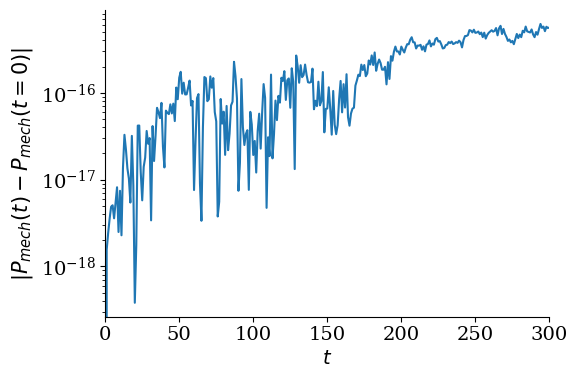

In [65]:
# plot momentum conservation
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(sol_midpoint_t, np.abs(momentum_midpoint - momentum_midpoint[0]), "-")
ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"$|P_{mech}(t)-P_{mech}(t=0)|$", fontsize=15)
ax.set_xlabel("$t$")
ax.set_xlim(0, T)
plt.tight_layout()

### energy conservation

In [66]:
# compute energy (kinetic + potential)
energy_k_midpoint = np.zeros(len(sol_midpoint_t))
energy_p_midpoint = np.zeros(len(sol_midpoint_t))

for ii in range(0, len(sol_midpoint_t)):
    energy_k_midpoint[ii] = total_energy_k(state=state_e_midpoint[:, :, ii], alpha_s=alpha_e, dx=dx, Nv=Nv, m_s=m_e, u_s=u_e)\
                           +total_energy_k(state=state_i_midpoint[:, :, ii], alpha_s=alpha_i, dx=dx, Nv=Nv, m_s=m_i, u_s=u_i)
    
    energy_p_midpoint[ii] = 0.5*dx*np.sum((E_midpoint[:, ii])**2)

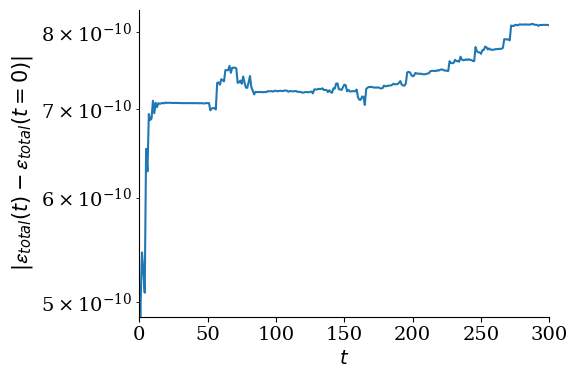

In [67]:
# plot energy conservation
fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(sol_midpoint_t, np.abs(energy_p_midpoint + energy_k_midpoint -energy_p_midpoint[0]-energy_k_midpoint[0]), "-")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"$|\mathcal{\epsilon}_{total}(t)-\mathcal{\epsilon}_{total}(t=0)|$", fontsize=15)
ax.set_xlabel("$ t$")
ax.set_xlim(0, T)
ax.set_yscale("log")
plt.tight_layout()

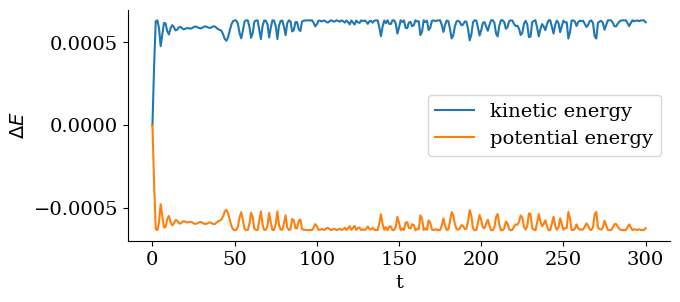

In [68]:
# plot the kinetic + potential energy exchange
fig, ax = plt.subplots(figsize=(7, 3))
plt.plot(sol_midpoint_t, energy_k_midpoint- energy_k_midpoint[0], label="kinetic energy")
plt.plot(sol_midpoint_t, energy_p_midpoint- energy_p_midpoint[0], label="potential energy")
plt.legend()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel("t")
_ = ax.set_ylabel(r"$\Delta E$")

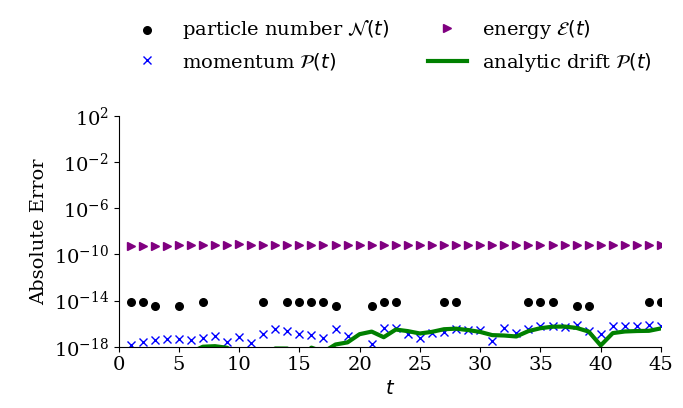

In [69]:
# plot the analytic and numerical conservation properties
fig, ax = plt.subplots(figsize=(7, 3))
ax.scatter(sol_midpoint_t, np.abs(mass_midpoint-mass_midpoint[0]), s=30, color="black", label=r"particle number $\mathcal{N}(t)$")
ax.plot(sol_midpoint_t, np.abs(momentum_midpoint-momentum_midpoint[0]), "x", color="blue", label=r"momentum $\mathcal{P}(t)$")
ax.plot(sol_midpoint_t, np.abs(energy_p_midpoint + energy_k_midpoint -energy_p_midpoint[0]-energy_k_midpoint[0]), ">", color="purple", label=r"energy $\mathcal{E}(t)$")
#ax.plot(sol_midpoint_t, np.abs(sol_midpoint_u[-1]), "--", c="orange", linewidth=3, label=r"analytic drift $\mathcal{N}(t)$ ")
#ax.plot(sol_midpoint_t, np.abs(sol_midpoint_u[-5]), ":", c="red", linewidth=3, label=r"analytic drift $\mathcal{E}(t)$")
ax.plot(sol_midpoint_t, np.abs(sol_midpoint_u[-2]), "-", c="green", linewidth=3, label=r"analytic drift $\mathcal{P}(t)$")
ax.set_ylim(10**-18, 100)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"Absolute Error")
ax.set_xlabel("$t$")
ax.set_xlim(0, 45)
ax.set_yscale("log")
legend = ax.legend(ncols=2, fontsize=14, loc='upper center', bbox_to_anchor=(0.5, 1.5))
text = ax.text(-0.2,1.05, " ", transform=ax.transAxes)
legend.get_frame().set_alpha(0)
plt.savefig("../figs/SW/nonlinear_landau/conservation_" + str(Nv) + "_nonlinear_landau_SW.png", bbox_extra_artists=(legend,text), bbox_inches='tight', dpi=600)

In [40]:
maximum_swsr = np.load("../data/SW_sqrt/nonlinear_landau/maximum_vector.npy")
minimum_swsr = np.load("../data/SW_sqrt/nonlinear_landau/minimum_vector.npy")

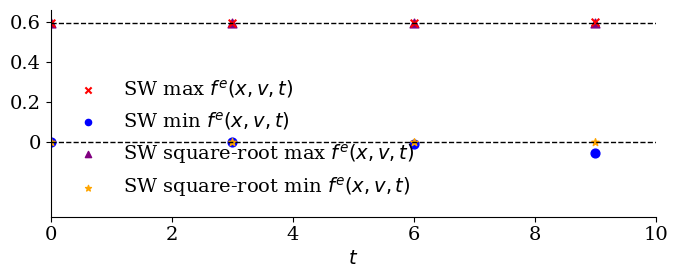

In [31]:
fig, ax = plt.subplots(figsize=(7, 3))
for tt, ii in enumerate(range(0, len(sol_midpoint_t), 30)):
    distribution = np.zeros((Nx, len(v)))
    for jj in range(Nv):
        distribution += np.outer(np.append(state_e_midpoint[jj, :, ii], state_e_midpoint[jj, 0, ii]), psi_ln_sw(xi=(v-u_e)/alpha_e, u_s=u_e, alpha_s=alpha_e, v=v, n=jj))
    ax.scatter(sol_midpoint_t[ii], maximum_swsr[tt], marker="^", c="purple", s=40)
    ax.scatter(sol_midpoint_t[ii], np.nanmax(distribution), marker="x", c="r", s=30)
    ax.scatter(sol_midpoint_t[ii], np.nanmin(distribution), marker="o", c="b", s=40)
    ax.scatter(sol_midpoint_t[ii], minimum_swsr[tt], marker="*", c="orange", s=30)
ax.set_xlabel("$t$")
ax.set_xlim(0, 10)
ax.axhline(y=0, c="black", ls="--", linewidth=1)  
ax.axhline(y=0.598413, c="black", ls="--", linewidth=1)  
ax.scatter(np.nan, np.nan, c="r", marker="x", s=20, label="SW max $f^{e}(x, v, t)$")
ax.scatter(np.nan, np.nan, c="b", marker="o", s=20, label="SW min $f^{e}(x, v, t)$")
ax.scatter(np.nan, np.nan, c="purple", marker="^", s=20, label="SW square-root max $f^{e}(x, v, t)$")
ax.scatter(np.nan, np.nan, c="orange", marker="*", s=20, label="SW square-root min $f^{e}(x, v, t)$")
legend = ax.legend(ncols=1, fancybox=False, shadow=False, fontsize=14)
legend.get_frame().set_alpha(0)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_yticks([0, 0.2, 0.4, 0.6])
ax.set_yticklabels(["0", "0.2", "0.4", "0.6"])
plt.tight_layout()
plt.savefig("../figs/SW/nonlinear_landau/distribution_maxima_nonlinear_landau.png", dpi=500)

In [27]:
E1_SW_100 = np.load("../data/SW/nonlinear_landau/E1_evolution_100.npy")
E1_SW_101 = np.load("../data/SW/nonlinear_landau/E1_evolution_101.npy")
E1_SWSR_100 = np.load("../data/SW_sqrt/nonlinear_landau/E1_evolution_100.npy")
E1_SWSR_101 = np.load("../data/SW_sqrt/nonlinear_landau/E1_evolution_101.npy")

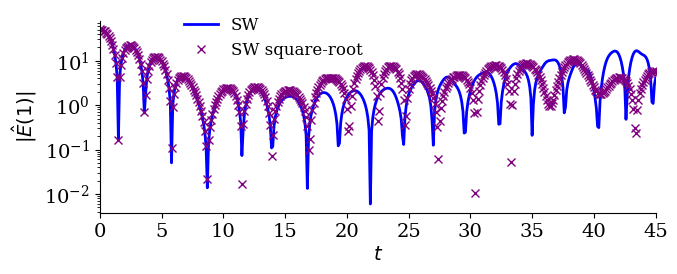

In [33]:
# plot electric field damping rate
fig, ax = plt.subplots(figsize=(7, 3))
ax.plot(sol_midpoint_t, E1_SW_100, "-", c="blue", linewidth=2, label="SW") 
ax.plot(sol_midpoint_t, E1_SWSR_100, "x", c="purple", linewidth=2, label="SW square-root") 

ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel("$|\hat{E}(1)|$")
ax.set_xlabel("$t$")
ax.set_xlim(0, 45)
legend = ax.legend(ncols=1, fancybox=False, shadow=False, fontsize=12, loc='upper right', bbox_to_anchor=(0.5, 1.1))
legend.get_frame().set_alpha(0)
plt.tight_layout()
plt.savefig("../figs/SW/nonlinear_landau/electric_field_damping_nonlinear_landau", dpi=600)